<a href="https://colab.research.google.com/github/lc2232/InteriorSegmentor/blob/main/new_seg_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MMSegmentation Tutorial
Welcome to MMSegmentation! 

In this tutorial, we demo
* How to do inference with MMSeg trained weight
* How to train on your own dataset and visualize the results. 

## Install MMSegmentation
This step may take several minutes. 

We use PyTorch 1.12 and CUDA 11.3 for this tutorial. You may install other versions by change the version number in pip install command. 

In [ ]:
# Check nvcc version
!nvcc -V
# Check GCC version
!gcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0
gcc (Ubuntu 9.4.0-1ubuntu1~20.04.1) 9.4.0
Copyright (C) 2019 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [ ]:
# Install PyTorch
!conda install pytorch==1.12.0 torchvision==0.13.0 torchaudio==0.12.0 cudatoolkit=11.3 -c pytorch
# Install mim
!pip install -U openmim
# Install mmengine
!mim install mmengine
# Install MMCV
!mim install 'mmcv >= 2.0.0rc1'


/bin/bash: conda: command not found
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.3/51.3 KB 2.3 MB/s eta 0:00:00
/usr/local/lib/python3.9/dist-packages/setuptools/command/install.py:34: SetuptoolsDeprecationWarning: setup.py install is deprecated. Use build and pip and other standards-based tools.
  warnings.warn(
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.openmmlab.com/mmcv/dist/cu116/torch1.13.0/index.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.8/365.8 KB 26.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.2/190.2 KB 25.9 MB/s eta 0:00:00
/usr/local/lib/python3.9/dist-packages/setuptools/command/install.py:34: SetuptoolsDeprecationWarning: setup.py install is deprecated. Use build and pip and other standards-based tools.
  warnings.warn(
/usr/local/lib/python3.9/dist-

In [ ]:
!rm -rf mmsegmentation
!git clone -b dev-1.x https://github.com/open-mmlab/mmsegmentation.git 
%cd mmsegmentation
!pip install -e .

Cloning into 'mmsegmentation'...
remote: Enumerating objects: 14566, done.
remote: Counting objects: 100% (153/153), done.
remote: Compressing objects: 100% (143/143), done.
remote: Total 14566 (delta 26), reused 41 (delta 7), pack-reused 14413
Receiving objects: 100% (14566/14566), 17.84 MiB | 17.27 MiB/s, done.
Resolving deltas: 100% (10340/10340), done.
/content/mmsegmentation
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining file:///content/mmsegmentation
  Preparing metadata (setup.py) ... done
  Running setup.py develop for mmsegmentation


In [ ]:
# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check MMSegmentation installation
import mmseg
print(mmseg.__version__)

1.13.1+cu116 True
1.0.0rc6


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')


!mkdir dataset
!cp /content/drive/MyDrive/Interior/compiled_dataset.zip /content/mmsegmentation/dataset/
!ls
!unzip /content/mmsegmentation/dataset/compiled_dataset.zip -d /content/mmsegmentation/dataset/


Mounted at /content/drive/
CITATION.cff  docs		       model-index.yml	requirements.txt  tools
configs       LICENSE		       projects		resources
dataset       MANIFEST.in	       README.md	setup.cfg
demo	      mmseg		       README_zh-CN.md	setup.py
docker	      mmsegmentation.egg-info  requirements	tests
Archive:  /content/mmsegmentation/dataset/compiled_dataset.zip
   creating: /content/mmsegmentation/dataset/compiled_dataset/
  inflating: /content/mmsegmentation/dataset/compiled_dataset/.DS_Store  
  inflating: /content/mmsegmentation/dataset/__MACOSX/compiled_dataset/._.DS_Store  
  inflating: /content/mmsegmentation/dataset/compiled_dataset/cocolabel.json  
   creating: /content/mmsegmentation/dataset/compiled_dataset/label/
   creating: /content/mmsegmentation/dataset/compiled_dataset/cam/
  inflating: /content/mmsegmentation/dataset/compiled_dataset/label/348.png  
  inflating: /content/mmsegmentation/dataset/compiled_dataset/label/1804.png  
  inflating: /content/mmsegmentation/da

## Finetune a semantic segmentation model on a new dataset

To finetune on a customized dataset, the following steps are necessary. 
1. Add a new dataset class. 
2. Create a config file accordingly. 
3. Perform training and evaluation. 

### Add a new dataset

Datasets in MMSegmentation require image and semantic segmentation maps to be placed in folders with the same prefix. To support a new dataset, we may need to modify the original file structure. 

In this tutorial, we give an example of converting the dataset. You may refer to [docs](https://github.com/open-mmlab/mmsegmentation/blob/master/docs/en/tutorials/customize_datasets.md#customize-datasets-by-reorganizing-data) for details about dataset reorganization. 

We use [Stanford Background Dataset](http://dags.stanford.edu/projects/scenedataset.html) as an example. The dataset contains 715 images chosen from existing public datasets [LabelMe](http://labelme.csail.mit.edu), [MSRC](http://research.microsoft.com/en-us/projects/objectclassrecognition), [PASCAL VOC](http://pascallin.ecs.soton.ac.uk/challenges/VOC) and [Geometric Context](http://www.cs.illinois.edu/homes/dhoiem/). Images from these datasets are mainly outdoor scenes, each containing approximately 320-by-240 pixels. 
In this tutorial, we use the region annotations as labels. There are 8 classes in total, i.e. sky, tree, road, grass, water, building, mountain, and foreground object. 

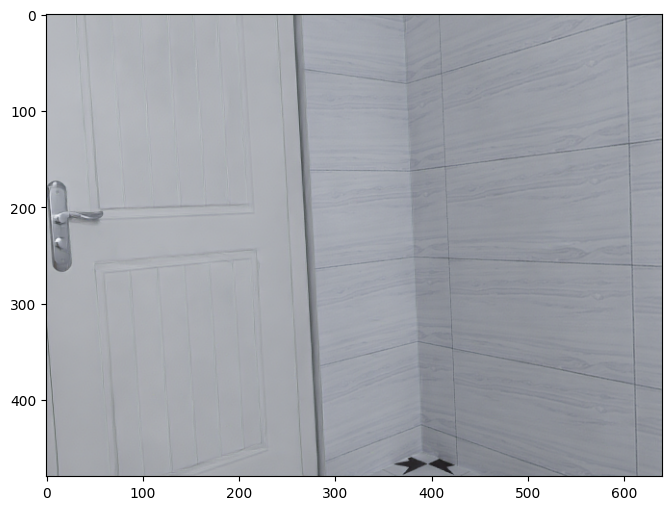

In [ ]:
# Let's take a look at the dataset
import mmcv
import mmengine
import matplotlib.pyplot as plt


img = mmcv.imread('/content/mmsegmentation/dataset/compiled_dataset/cam/0.png')
plt.figure(figsize=(8, 6))
plt.imshow(mmcv.bgr2rgb(img))
plt.show()

In [ ]:
# import cv2

# img = mmcv.imread('/content/mmsegmentation/dataset/compiled_dataset/label/0.png')
# plt.figure(figsize=(8, 6))
# plt.imshow(mmcv.bgr2rgb(img))
# plt.show()

# # load an image in grayscale mode
# nyu_img = cv2.imread('/content/mmsegmentation/dataset/compiled_dataset/label/0.png',0)
# # find frequency of pixels in range 0-255
# plt.imshow(mmcv.bgr2rgb(nyu_img))
# plt.show()

# histr = cv2.calcHist([nyu_img],[0],None,[10],[0,10])
# # show the plotting graph of an image
# plt.plot(histr)
# plt.show()

# dst = cv2.equalizeHist(nyu_img)
# plt.imshow(mmcv.bgr2rgb(dst))
# plt.show()
  

# histr1 = cv2.calcHist([dst],[0],None,[10],[0,10])
# # show the plotting graph of an image
# plt.plot(histr1)
# plt.show()




We need to convert the annotation into semantic map format as an image.

In [ ]:
# define dataset root and directory for images and annotations
import json

data_root = '/content/mmsegmentation/dataset/compiled_dataset/'
img_dir = 'cam'
ann_dir = 'label'

classes = ['wall', 'floor', 'cabinet', 'bed', 'chair', 'sofa', 'table', 'door', 'window', 'bookshelf', 'picture', 'counter', 'blinds', 'desk', 'shelves', 'curtain', 'dresser', 'pillow', 'mirror', 'floor', 'clothes', 'ceiling', 'books', 'refridgerator', 'television', 'paper', 'towel', 'shower', 'box', 'whiteboard', 'person', 'night', 'toilet', 'sink', 'lamp', 'bathtub', 'bag', 'otherstructure', 'otherfurniture', 'otherprop']



palette = [[118, 21, 12], [55,125,33], [129,129.32], [0,0,116], [117,21,124], [56, 127, 128], [129,129,129], [56, 5, 3], [177, 36, 24], [56,5,59], [184,132,44], [56,5,124], [188,0,5] ,[79,127,128], [184,132,130], [23,61,11], [116,63,19], [65,142,41], [143,192,58], [56,127,34], [0,0,0],  [87,191,134], [0,0,0], [62,62,14], [179,72,29], [0,0,0], [0,0,0], [0,0,0], [0,0,0], [0,0,0], [0,0,0], [0,0,59],[56,127,69], [129,129,71], [0,0,185], [0,0,0], [0,0,0],[129,129,189], [0,0,0],[0,0,0]]

print(len(palette))

print(len(classes))

40
40


In [ ]:
import os.path as osp


In [ ]:
# split train/val set randomly
split_dir = 'splits'
mmengine.mkdir_or_exist(osp.join(data_root, split_dir))
filename_list = [osp.splitext(filename)[0] for filename in mmengine.scandir(
    osp.join(data_root, ann_dir), suffix='.png')]
with open(osp.join(data_root, split_dir, 'train.txt'), 'w') as f:
  # select first 4/5 as train set
  train_length = int(len(filename_list)*910/1000)
  f.writelines(line + '\n' for line in filename_list[:train_length])
with open(osp.join(data_root, split_dir, 'val.txt'), 'w') as f:
  # select last 1/5 as train set
  f.writelines(line + '\n' for line in filename_list[train_length:])

After downloading the data, we need to implement `load_annotations` function in the new dataset class `StanfordBackgroundDataset`.

In [ ]:
from mmseg.registry import DATASETS
from mmseg.datasets import BaseSegDataset


@DATASETS.register_module()
class StanfordBackgroundDataset(BaseSegDataset):
  METAINFO = dict(classes = classes, palette = palette)
  def __init__(self, **kwargs):
    super().__init__(img_suffix='.png', seg_map_suffix='.png', **kwargs)
    

### Create a config file
In the next step, we need to modify the config for the training. To accelerate the process, we finetune the model from trained weights.

In [ ]:
# Download config and checkpoint files
# !mim download mmsegmentation --config pspnet_r50-d8_4xb2-40k_cityscapes-512x1024 --dest .


# !wget https://conversationhub.blob.core.windows.net/beit-share-public/beit/beit_base_patch16_224_pt22k_ft22k.pth -P checkpoints
# !python /content/mmsegmentation/tools/model_converters/beit2mmseg.py https://conversationhub.blob.core.windows.net/beit-share-public/beit/beit_base_patch16_224_pt22k_ft22k.pth pretrain/beit_base_patch16_224_pt22k_ft22k.pth

# !python tools/model_converters/vit2mmseg.py https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-vitjx/jx_vit_base_p16_224-80ecf9dd.pth pretrain/jx_vit_base_p16_224-80ecf9dd.pth

config_file = 'configs/resnest/resnest_s101-d8_deeplabv3plus_4xb4-160k_ade20k-512x512.py'
checkpoint_file = 'checkpoints/deeplabv3plus_s101-d8_512x512_160k_ade20k_20200807_144503-27b26226.pth'


In [ ]:
from mmengine import Config
cfg = Config.fromfile(config_file)
print(f'Config:\n{cfg.pretty_text}')

Config:
norm_cfg = dict(type='SyncBN', requires_grad=True)
data_preprocessor = dict(
    type='SegDataPreProcessor',
    mean=[123.675, 116.28, 103.53],
    std=[58.395, 57.12, 57.375],
    bgr_to_rgb=True,
    pad_val=0,
    seg_pad_val=255,
    size=(512, 512))
model = dict(
    type='EncoderDecoder',
    data_preprocessor=dict(
        type='SegDataPreProcessor',
        mean=[123.675, 116.28, 103.53],
        std=[58.395, 57.12, 57.375],
        bgr_to_rgb=True,
        pad_val=0,
        seg_pad_val=255,
        size=(512, 512)),
    pretrained='open-mmlab://resnest101',
    backbone=dict(
        type='ResNeSt',
        depth=101,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        dilations=(1, 1, 2, 4),
        strides=(1, 2, 1, 1),
        norm_cfg=dict(type='SyncBN', requires_grad=True),
        norm_eval=False,
        style='pytorch',
        contract_dilation=True,
        stem_channels=128,
        radix=2,
        reduction_factor=4,
        avg_down_stride=T

In [ ]:
# Since we use only one GPU, BN is used instead of SyncBN
cfg.norm_cfg = dict(type='BN', requires_grad=True)
cfg.crop_size = (640,480)
cfg.model.data_preprocessor.size = cfg.crop_size
cfg.model.backbone.norm_cfg = cfg.norm_cfg
cfg.model.decode_head.norm_cfg = cfg.norm_cfg
cfg.model.auxiliary_head.norm_cfg = cfg.norm_cfg
# modify num classes of the model in decode/auxiliary head
cfg.model.decode_head.num_classes = 40
cfg.model.auxiliary_head.num_classes = 40

# Modify dataset type and path
cfg.dataset_type = 'StanfordBackgroundDataset'
cfg.data_root = data_root

cfg.train_dataloader.batch_size = 8

cfg.train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations'),
    dict(type='RandomResize', scale=(320, 240), ratio_range=(0.5, 2.0), keep_ratio=True),
    dict(type='RandomCrop', crop_size=cfg.crop_size, cat_max_ratio=0.75),
    dict(type='RandomFlip', prob=0.5),
    dict(type='PackSegInputs')
]

cfg.test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='Resize', scale=(320, 240), keep_ratio=True),
    # add loading annotation after ``Resize`` because ground truth
    # does not need to do resize data transform
    dict(type='LoadAnnotations'),
    dict(type='PackSegInputs')
]


cfg.train_dataloader.dataset.type = cfg.dataset_type
cfg.train_dataloader.dataset.data_root = cfg.data_root
cfg.train_dataloader.dataset.data_prefix = dict(img_path=img_dir, seg_map_path=ann_dir)
cfg.train_dataloader.dataset.pipeline = cfg.train_pipeline
cfg.train_dataloader.dataset.ann_file = 'splits/train.txt'

cfg.val_dataloader.dataset.type = cfg.dataset_type
cfg.val_dataloader.dataset.data_root = cfg.data_root
cfg.val_dataloader.dataset.data_prefix = dict(img_path=img_dir, seg_map_path=ann_dir)
cfg.val_dataloader.dataset.pipeline = cfg.test_pipeline
cfg.val_dataloader.dataset.ann_file = 'splits/val.txt'

cfg.test_dataloader = cfg.val_dataloader


# Load the pretrained weights
cfg.load_from = checkpoint_file

# Set up working dir to save files and logs.
cfg.work_dir = './work_dirs/tutorial'

cfg.train_cfg.max_iters = 5000
cfg.train_cfg.val_interval = 1000
cfg.default_hooks.logger.interval = 500
cfg.default_hooks.checkpoint.interval = 500
cfg.default_hooks.visualization.interval = 500
cfg.default_hooks.visualization.draw = True

# Set seed to facilitate reproducing the result
cfg['randomness'] = dict(seed=0)

# Let's have a look at the final config used for training
print(f'Config:\n{cfg.pretty_text}')

Config:
norm_cfg = dict(type='BN', requires_grad=True)
data_preprocessor = dict(
    type='SegDataPreProcessor',
    mean=[123.675, 116.28, 103.53],
    std=[58.395, 57.12, 57.375],
    bgr_to_rgb=True,
    pad_val=0,
    seg_pad_val=255,
    size=(512, 512))
model = dict(
    type='EncoderDecoder',
    data_preprocessor=dict(
        type='SegDataPreProcessor',
        mean=[123.675, 116.28, 103.53],
        std=[58.395, 57.12, 57.375],
        bgr_to_rgb=True,
        pad_val=0,
        seg_pad_val=255,
        size=(640, 480)),
    pretrained='open-mmlab://resnest101',
    backbone=dict(
        type='ResNeSt',
        depth=101,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        dilations=(1, 1, 2, 4),
        strides=(1, 2, 1, 1),
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=False,
        style='pytorch',
        contract_dilation=True,
        stem_channels=128,
        radix=2,
        reduction_factor=4,
        avg_down_stride=True),
  

Since the given config is used to train PSPNet on the cityscapes dataset, we need to modify it accordingly for our new dataset.  

### Train and Evaluation

In [ ]:
!mkdir checkpoints
!wget https://download.openmmlab.com/mmsegmentation/v0.5/pspnet/pspnet_r50-d8_512x1024_40k_cityscapes/pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth -P checkpoints
# !wget https://conversationhub.blob.core.windows.net/beit-share-public/beit/beit_base_patch16_224_pt22k_ft22k.pth -P checkpoints
# !wget https://download.openmmlab.com/mmsegmentation/v0.5/resnest/deeplabv3plus_s101-d8_512x512_160k_ade20k/deeplabv3plus_s101-d8_512x512_160k_ade20k_20200807_144503-27b26226.pth -P checkpoints
# !python /content/mmsegmentation/tools/model_converters/beit2mmseg.py https://conversationhub.blob.core.windows.net/beit-share-public/beit/beit_base_patch16_224_pt22k_ft22k.pth pretrain/beit_base_patch16_224_pt22k_ft22k.pth
!wget https://download.openmmlab.com/mmsegmentation/v0.5/resnest/deeplabv3plus_s101-d8_512x512_160k_ade20k/deeplabv3plus_s101-d8_512x512_160k_ade20k_20200807_144503-27b26226.pth -P checkpoints

# !python tools/model_converters/vit2mmseg.py https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-vitjx/jx_vit_base_p16_224-80ecf9dd.pth pretrain/jx_vit_base_p16_224-80ecf9dd.pth

--2023-03-31 10:19:00--  https://download.openmmlab.com/mmsegmentation/v0.5/pspnet/pspnet_r50-d8_512x1024_40k_cityscapes/pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 163.181.82.214, 163.181.82.212, 163.181.82.215, ...
Connecting to download.openmmlab.com (download.openmmlab.com)|163.181.82.214|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 196205945 (187M) [application/octet-stream]
Saving to: ‘checkpoints/pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth’

pspnet_r50-d8_512x1 100%[===================>] 187.12M   203MB/s    in 0.9s    

2023-03-31 10:19:01 (203 MB/s) - ‘checkpoints/pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth’ saved [196205945/196205945]

--2023-03-31 10:19:01--  https://download.openmmlab.com/mmsegmentation/v0.5/resnest/deeplabv3plus_s101-d8_512x512_160k_ade20k/deeplabv3plus_s101-d8_512x512_160k_ade20k_20200807_144503-27b

In [ ]:
from mmengine.runner import Runner

runner = Runner.from_cfg(cfg)

03/31 10:19:04 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.9.16 (main, Dec  7 2022, 01:11:51) [GCC 9.4.0]
    CUDA available: True
    numpy_random_seed: 0
    GPU 0: NVIDIA A100-SXM4-40GB
    CUDA_HOME: /usr/local/cuda
    NVCC: Cuda compilation tools, release 11.8, V11.8.89
    GCC: x86_64-linux-gnu-gcc (Ubuntu 9.4.0-1ubuntu1~20.04.1) 9.4.0
    PyTorch: 1.13.1+cu116
    PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201402
  - Intel(R) Math Kernel Library Version 2020.0.0 Product Build 20191122 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.6.0 (Git Hash 52b5f107dd9cf10910aaa19cb47f3abf9b349815)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 11.6
  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;arch=compute_50,

/content/mmsegmentation/mmseg/models/backbones/resnet.py:431: UserWarning: DeprecationWarning: pretrained is a deprecated, please use "init_cfg" instead
  warnings.warn('DeprecationWarning: pretrained is a deprecated, '
/content/mmsegmentation/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/content/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:235: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


03/31 10:19:12 - mmengine - INFO - Distributed training is not used, all SyncBatchNorm (SyncBN) layers in the model will be automatically reverted to BatchNormXd layers if they are used.
03/31 10:19:12 - mmengine - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) RuntimeInfoHook                    
(BELOW_NORMAL) LoggerHook                         
 -------------------- 
before_train:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
(VERY_LOW    ) CheckpointHook                     
 -------------------- 
before_train_epoch:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
(NORMAL      ) DistSamplerSeedHook                
 -------------------- 
before_train_iter:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
 -------------------- 
after_train_iter:
(VERY_HIGH   ) RuntimeInfoHook                

In [ ]:
from mmseg.apis import init_model, inference_model, show_result_pyplot

import numpy as np

# # Init the model from the config and the checkpoint
# model = init_model(cfg, checkpoint_file, 'cuda:0')

# # print(model.dataset_meta['classes'])
# # print(model.dataset_meta['palette'])

# # colors = [palette[label] for label in labels]

# # print(colors)

# img = mmcv.imread('/content/mmsegmentation/dataset/compiled_dataset/cam/0.png')
# result = inference_model(model, img)
# plt.figure(figsize=(8, 6))
# vis_result = show_result_pyplot(model, img, result, save_dir='output.png')
# plt.imshow(mmcv.bgr2rgb(vis_result))

In [ ]:
# start training
runner.train()

03/31 10:19:12 - mmengine - WARNING - The "loop" registry in mmseg did not set import location. Fallback to call `mmseg.utils.register_all_modules` instead.
03/31 10:19:12 - mmengine - WARNING - Failed to import mmseg.datasets.samplers, please check the location of the registry data sampler is correct.
03/31 10:19:13 - mmengine - WARNING - Failed to import mmseg.engine.schedulers, please check the location of the registry parameter scheduler is correct.
03/31 10:19:13 - mmengine - WARNING - The prefix is not set in metric class IoUMetric.
03/31 10:19:13 - mmengine - INFO - load model from: open-mmlab://resnest101
03/31 10:19:13 - mmengine - INFO - Loads checkpoint by openmmlab backend from path: open-mmlab://resnest101


Downloading: "https://download.openmmlab.com/pretrain/third_party/resnest101_d2-f3b931b2.pth" to /root/.cache/torch/hub/checkpoints/resnest101_d2-f3b931b2.pth


Loads checkpoint by local backend from path: checkpoints/deeplabv3plus_s101-d8_512x512_160k_ade20k_20200807_144503-27b26226.pth
The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_seg.weight: copying a param with shape torch.Size([150, 512, 1, 1]) from checkpoint, the shape in current model is torch.Size([40, 512, 1, 1]).
size mismatch for decode_head.conv_seg.bias: copying a param with shape torch.Size([150]) from checkpoint, the shape in current model is torch.Size([40]).
size mismatch for auxiliary_head.conv_seg.weight: copying a param with shape torch.Size([150, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([40, 256, 1, 1]).
size mismatch for auxiliary_head.conv_seg.bias: copying a param with shape torch.Size([150]) from checkpoint, the shape in current model is torch.Size([40]).
03/31 10:19:15 - mmengine - INFO - Load checkpoint from checkpoints/deeplabv3plus_s101-d8_512x512_160k_ade20k_20200807_144503-27b26226.pth
03/31

EncoderDecoder(
  (data_preprocessor): SegDataPreProcessor()
  (backbone): ResNeSt(
    (stem): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU(inplace=True)
    )
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): ResLayer(
      (0): Bottleneck(
        (conv1): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-

Inference with trained model

Loads checkpoint by local backend from path: /content/mmsegmentation/work_dirs/tutorial/iter_5000.pth


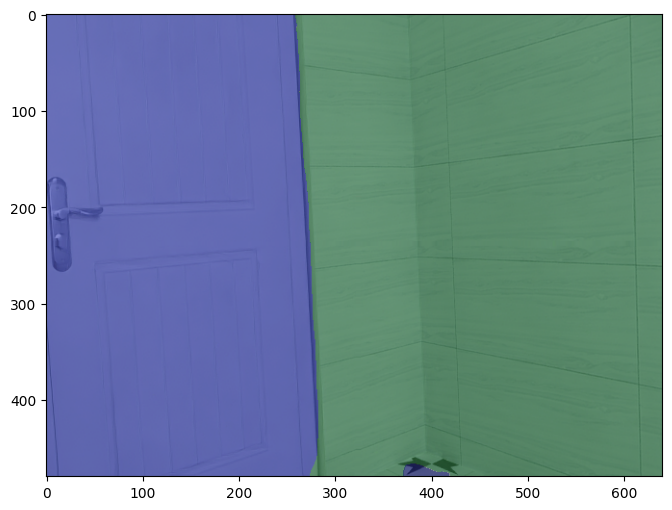

In [ ]:
from mmseg.apis import init_model, inference_model, show_result_pyplot

# # Init the model from the config and the checkpoint
checkpoint_path = '/content/mmsegmentation/work_dirs/tutorial/iter_5000.pth'
model = init_model(cfg, checkpoint_path,'cuda')

# print(len(model.dataset_meta['classes']))
# print(len(model.dataset_meta['palette']))

img = mmcv.imread('/content/mmsegmentation/dataset/compiled_dataset/cam/0.png')
result = inference_model(model, img)
plt.figure(figsize=(8, 6))
# print(result)
vis_result = show_result_pyplot(model, img, result, save_dir='/content/mmsegmentation/work_dirs/tutorial/20230327_093239')
plt.imshow(mmcv.bgr2rgb(vis_result))

In [ ]:
sh = """
#!/bin/bash
cp -r /content/mmsegmentation/work_dirs/tutorial/iter_1000.pth /content/drive/MyDrive/Checkpoints/1k_iters_2k_img.pth

cp -r /content/mmsegmentation/work_dirs/tutorial/iter_3000.pth /content/drive/MyDrive/Checkpoints/3k_iters_2k_img.pth

cp -r /content/mmsegmentation/work_dirs/tutorial/iter_5000.pth /content/drive/MyDrive/Checkpoints/5k_iters_2k_img.pth
"""
with open('script.sh', 'w') as file:
  file.write(sh)

!bash script.sh